# SDAB Melting Temperature Prediction using DL

### Load Modules and Datasets

In [1]:
### Initialize seed for reproducibility
import numpy as np
np.random.seed(0)
import math

### Data Wrangling and Plots
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 600
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from keras.models import Sequential
from keras.layers import Dense
import keras

2024-09-08 18:19:30.916703: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-08 18:19:30.939292: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def split_biased(data, y, split_column='source', holdout_var = "Camel"):
    """
    Create a split that holds out one group and splits the other one.
    """
    # data set for training
    x_train_all = data[meta[split_column] != holdout_var]
    y_train_all = y[meta[split_column] != holdout_var]

    #data set for validation
    x_val = data[meta[split_column] == holdout_var]
    y_val = y[meta[split_column] == holdout_var]

    #train, test split
    x_train, x_test, y_train, y_test = train_test_split(x_train_all, y_train_all, test_size=0.2, random_state=42)

    return x_train, y_train, x_test, y_test, x_val, y_val

### DL Model: Keras Sequential API for ANN

In [3]:
def create_model():
    model = Sequential([
        keras.layers.Dense(128, 
                           input_shape = (x.shape[1],), # input shape is the number of predictors
                           activation = 'relu'), # Input Layer
        keras.layers.Dense(256, 
                           activation = 'relu'), # Hidden Layer (mean of neurons in the input and output layers.)
        keras.layers.Dense(256, 
                           activation = 'relu'), # Hidden Layer (mean of neurons in the input and output layers.)
        keras.layers.Dense(256, 
                           activation = 'relu'), # Hidden Layer (mean of neurons in the input and output layers.)
        keras.layers.Dense(1, 
                           activation = 'linear') # If the NN is a regressor, then the output layer has a single node.
    ])
    
    model.compile(
        loss = 'mae',
        optimizer = 'adam',
        metrics= ['mae']
    )
    
    model.summary()

    return model

In [4]:
def compute_accuracies(model, x_test, y_test):
    """
    Compute the accuracies
    """

    mae = mean_absolute_error(y_test, model.predict(x_test))
    rmse = math.sqrt(mean_squared_error(y_test, model.predict(x_test)))
    coeff_det=r2_score(y_test, model.predict(x_test))
    return mae, rmse, coeff_det
    

#### Read training data from datafolder

In [5]:
data = pd.read_csv("../data/sdab_protein_embeddings_t6.csv", header = None)
data.head()
meta = pd.read_csv('../data/augmented_metadata.tsv')
y = pd.read_excel("../data/sdab_data.xlsx")

y = y.tm
x = data

In [6]:
meta.loc[meta.source.isin(['Arabian camel (Camelus dromedarius)', 'Dromedary']), 'source'] = "Dromedary"

# Biased trainings
## Split by species

In [7]:
species = ['Llama', 'Unknown', 'Camel', 'Alpaca', 'Human', 'Dromedary']
list_of_error = []
for animal in species:
    print(animal)
    x_train, y_train, x_test, y_test, x_val, y_val = split_biased(data, y, split_column='source', holdout_var = animal)
    callback = keras.callbacks.EarlyStopping(monitor='loss', patience=10)
    model = create_model()
    model_history = model.fit(x_train, y_train, epochs=500, batch_size=32, validation_data=(x_test, y_test), callbacks=callback)
    mae, rmse, coeff_det = compute_accuracies(model, x_val, y_val)
    list_of_error.append([animal, mae, rmse, coeff_det])

Llama


/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 67.6436 - mae: 67.6436 - val_loss: 60.2946 - val_mae: 60.2946
Epoch 2/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 58.9718 - mae: 58.9718 - val_loss: 34.3457 - val_mae: 34.3457
Epoch 3/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 26.6481 - mae: 26.6481 - val_loss: 21.6923 - val_mae: 21.6923
Epoch 4/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14.2978 - mae: 14.2978 - val_loss: 12.2938 - val_mae: 12.2938
Epoch 5/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 12.6025 - mae: 12.6025 - val_loss: 12.1784 - val_mae: 12.1784
Epoch 6/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 10.3580 - mae: 10.3580 - val_loss: 7.9471 - val_mae: 7.9471
Epoch 7/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.4226 - mae: 9.4226 - val_loss: 8.9529 - val_mae: 8.9529
Epoch 8/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.0726 - mae: 9.0726 - val_loss: 7.6545 - val_mae: 7.6545
Epoch 9/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 63.8966 - mae: 63.8966 - val_loss: 29.5183 - val_mae: 29.5183
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17.7506 - mae: 17.7506 - val_loss: 11.8659 - val_mae: 11.8659
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.9808 - mae: 9.9808 - val_loss: 9.2894 - val_mae: 9.2894
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.9268 - mae: 7.9268 - val_loss: 8.2688 - val_mae: 8.2688
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.5511 - mae: 7.5511 - val_loss: 8.2404 - val_mae: 8.2404
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.7345 - mae: 7.7345 - val_loss: 7.9829 - val_mae: 7.9829
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.6738 - mae: 7.6738 - val_loss: 9.0550 - val_mae: 9.0550
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.6589 - mae: 7.6589 - val_loss: 7.4893 - val_mae: 7.4893
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - los

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 64.2189 - mae: 64.2189 - val_loss: 53.9884 - val_mae: 53.9884
Epoch 2/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 40.8317 - mae: 40.8317 - val_loss: 23.5584 - val_mae: 23.5584
Epoch 3/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.4848 - mae: 16.4848 - val_loss: 13.5172 - val_mae: 13.5172
Epoch 4/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.5017 - mae: 9.5017 - val_loss: 8.2156 - val_mae: 8.2156
Epoch 5/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.0742 - mae: 9.0742 - val_loss: 8.4588 - val_mae: 8.4588
Epoch 6/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.0972 - mae: 9.0972 - val_loss: 9.2911 - val_mae: 9.2911
Epoch 7/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.3768 - mae: 8.3768 - val_loss: 7.9748 - val_mae: 7.9748
Epoch 8/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.9255 - mae: 7.9255 - val_loss: 7.7338 - val_mae: 7.7338
Epoch 9/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 64.8122 - mae: 64.8122 - val_loss: 31.5840 - val_mae: 31.5840
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.8238 - mae: 20.8238 - val_loss: 13.9903 - val_mae: 13.9903
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13.7328 - mae: 13.7328 - val_loss: 8.7104 - val_mae: 8.7104
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.3483 - mae: 9.3483 - val_loss: 9.1583 - val_mae: 9.1583
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.9150 - mae: 7.9150 - val_loss: 8.5109 - val_mae: 8.5109
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.3895 - mae: 8.3895 - val_loss: 9.0798 - val_mae: 9.0798
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.0075 - mae: 8.0075 - val_loss: 8.3522 - val_mae: 8.3522
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.3468 - mae: 8.3468 - val_loss: 8.3708 - val_mae: 8.3708
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 63.4551 - mae: 63.4551 - val_loss: 16.0518 - val_mae: 16.0518
Epoch 2/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14.2728 - mae: 14.2728 - val_loss: 9.5472 - val_mae: 9.5472
Epoch 3/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.9091 - mae: 8.9091 - val_loss: 9.2317 - val_mae: 9.2317
Epoch 4/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.1576 - mae: 8.1576 - val_loss: 9.1657 - val_mae: 9.1657
Epoch 5/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.0773 - mae: 8.0773 - val_loss: 9.0036 - val_mae: 9.0036
Epoch 6/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.0565 - mae: 8.0565 - val_loss: 8.8503 - val_mae: 8.8503
Epoch 7/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.5587 - mae: 7.5587 - val_loss: 8.7055 - val_mae: 8.7055
Epoch 8/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.6268 - mae: 7.6268 - val_loss: 8.8398 - val_mae: 8.8398
Epoch 9/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_25 (Dense)                │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 64.8379 - mae: 64.8379 - val_loss: 35.8612 - val_mae: 35.8612
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22.4622 - mae: 22.4622 - val_loss: 13.8378 - val_mae: 13.8378
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11.8910 - mae: 11.8910 - val_loss: 9.2385 - val_mae: 9.2385
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.0587 - mae: 9.0587 - val_loss: 8.9024 - val_mae: 8.9024
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.1426 - mae: 8.1426 - val_loss: 8.5659 - val_mae: 8.5659
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.9205 - mae: 7.9205 - val_loss: 9.0005 - val_mae: 9.0005
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.2028 - mae: 8.2028 - val_loss: 8.2989 - val_mae: 8.2989
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.6453 - mae: 7.6453 - val_loss: 8.1865 - val_mae: 8.1865
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - 

## Split into train/test and validation set 

In [8]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

callback = keras.callbacks.EarlyStopping(monitor='loss', patience=10)
model = create_model()
model_history = model.fit(x_train, y_train, epochs=500, batch_size=32, validation_data=(x_test, y_test), callbacks=callback)
amae, armse, acoeff_det = compute_accuracies(model, x_val, y_val)
list_of_error.append(['all', amae, armse, acoeff_det])

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 64.9088 - mae: 64.9088 - val_loss: 40.3381 - val_mae: 40.3381
Epoch 2/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 25.6735 - mae: 25.6735 - val_loss: 9.9687 - val_mae: 9.9687
Epoch 3/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11.7360 - mae: 11.7360 - val_loss: 12.9145 - val_mae: 12.9145
Epoch 4/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.1760 - mae: 9.1760 - val_loss: 8.3051 - val_mae: 8.3051
Epoch 5/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.0301 - mae: 8.0301 - val_loss: 8.6685 - val_mae: 8.6685
Epoch 6/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.2876 - mae: 8.2876 - val_loss: 8.2170 - val_mae: 8.2170
Epoch 7/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.5698 - mae: 7.5698 - val_loss: 8.5426 - val_mae: 8.5426
Epoch 8/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.9432 - mae: 7.9432 - val_loss: 9.0843 - val_mae: 9.0843
Epoch 9/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - 

## Collect all results

In [9]:
results1 = pd.DataFrame(list_of_error)
results1.columns = ['Species', 'MAE', 'RMSE', 'R2']
df_melted = results1.melt(id_vars='Species', value_vars=['MAE', 'RMSE', 'R2'], var_name='Metric', value_name='Value')
df_melted['color'] = 'black'
df_melted.loc[df_melted.Species == 'all', 'color']= 'red'

In [10]:
results1

,Species,MAE,RMSE,R2
0,Llama,7.169658,8.933474,0.183126
1,Unknown,10.081973,11.544842,0.251811
2,Camel,10.978923,12.569254,-0.811747
3,Alpaca,5.258536,6.959357,0.375848
4,Human,6.772415,8.302372,-0.631464
5,Dromedary,8.775226,9.949888,-0.878048
6,all,7.042751,8.837783,0.302452


## Compare the error achieved when training on a random dataset compare to the error when training on a biased split

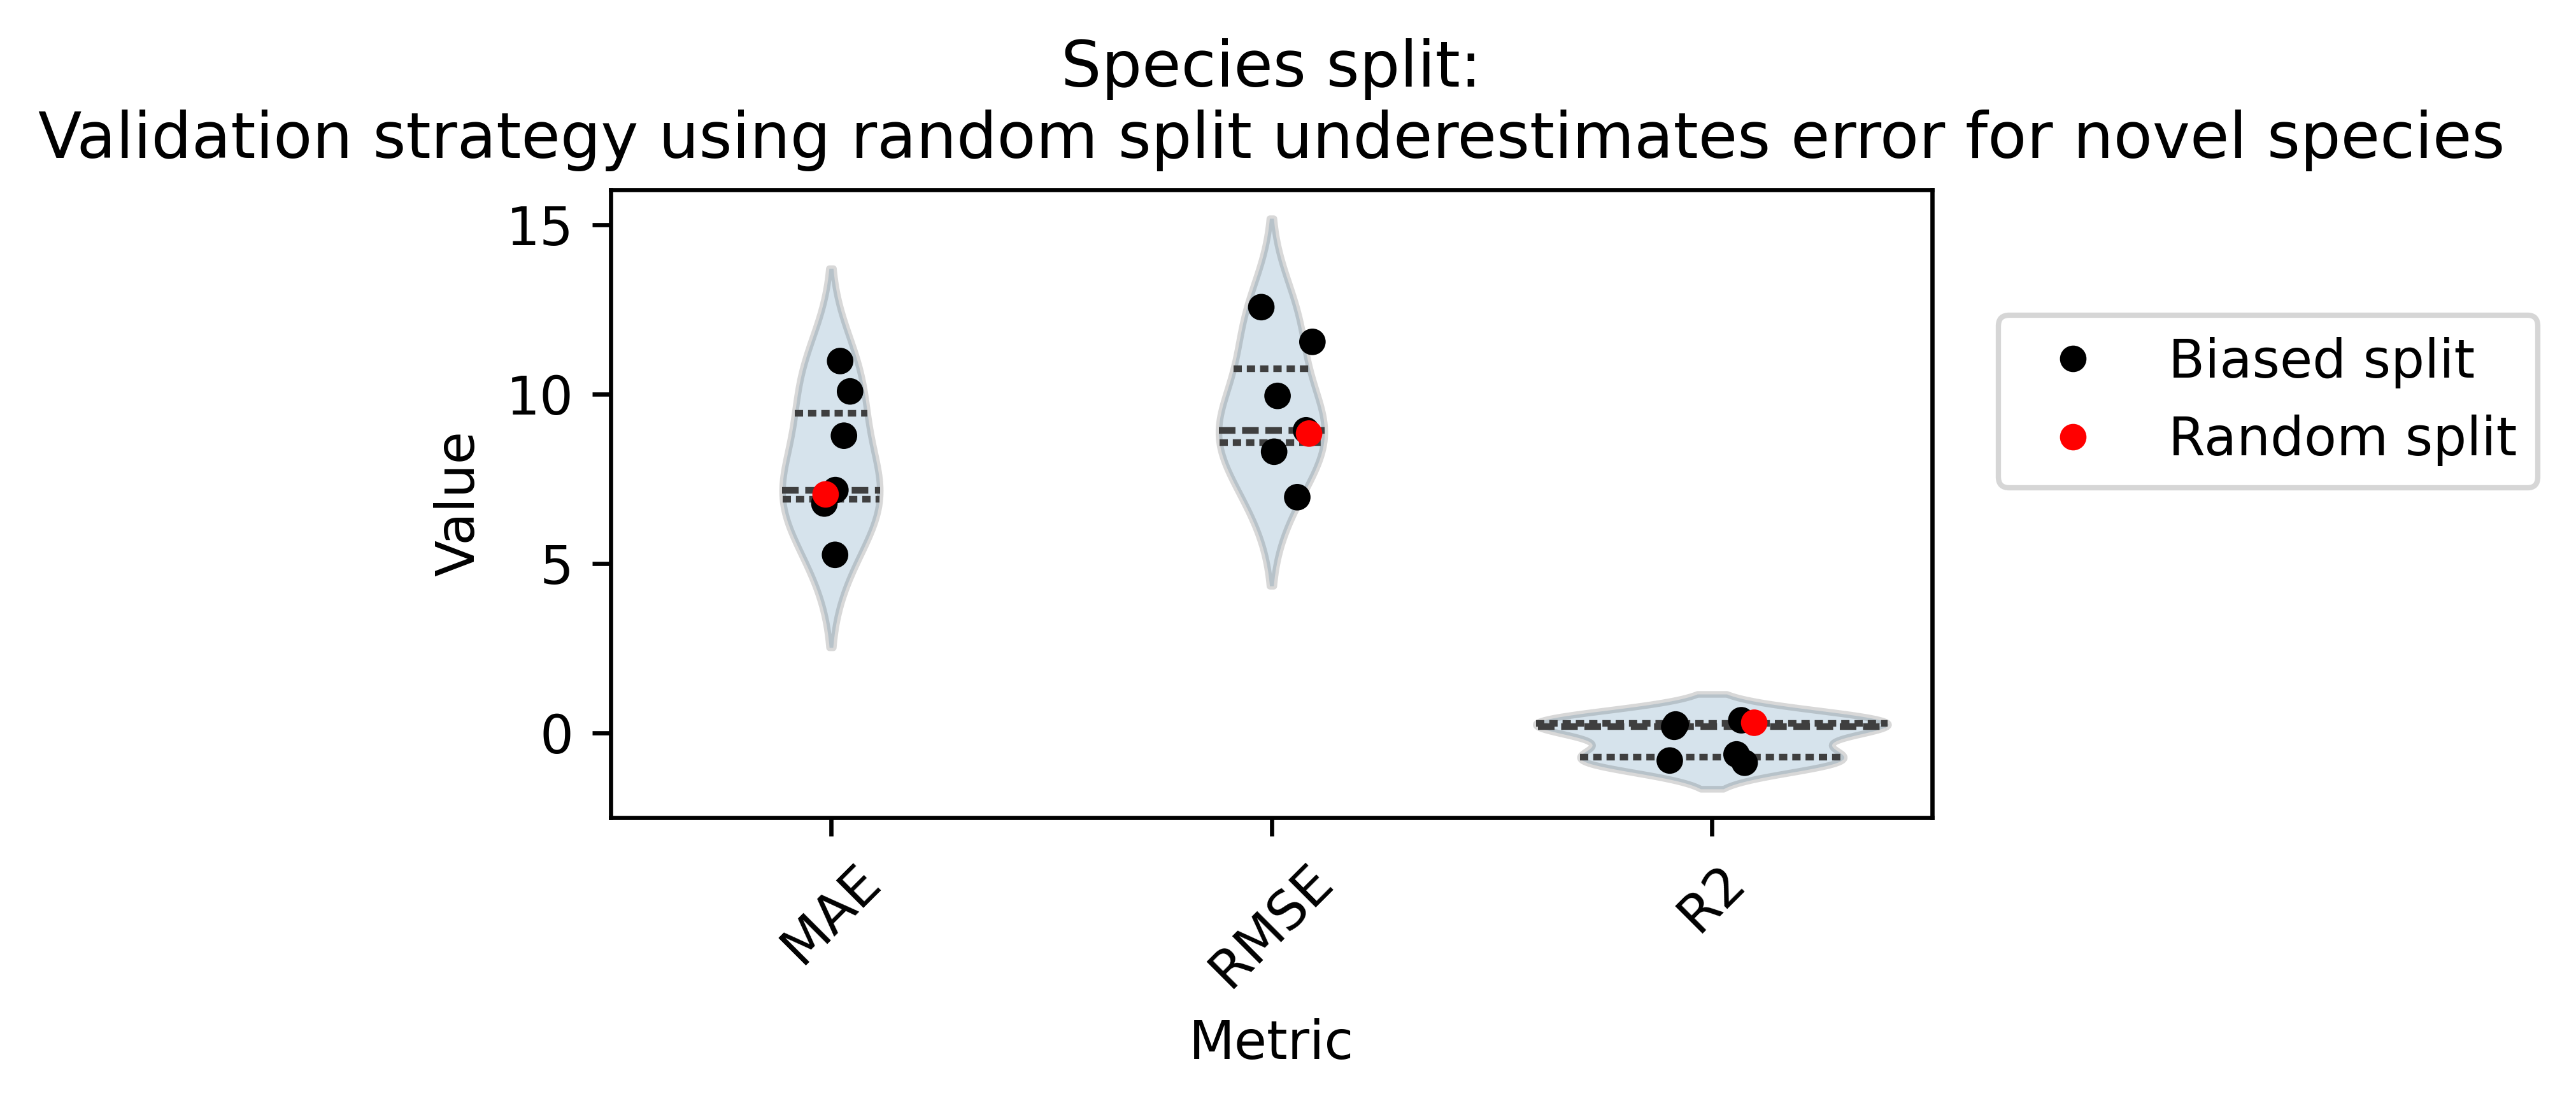

In [11]:
# Creating the boxplot
plt.figure(figsize=(6, 3))
sns.violinplot(x='Metric', y='Value', data=df_melted, alpha=0.2,inner='quart' )
plt.title('Species split:\nValidation strategy using random split underestimates error for novel species')
plt.xticks(rotation=45)
sns.stripplot(
    x='Metric', y='Value', data=df_melted,
    hue='color', dodge=False, palette={'red': 'red', 'black': 'black'}, jitter=True, marker='o',
)

handles, labels = plt.gca().get_legend_handles_labels()

# Combine handles and labels manually to update red point labels
species_labels = ['Biased split', 'Random split']
color_labels = ['Red Points (Alpaca & Dromedary)', 'Grey Points (Other Species)']

# Use only necessary handles and labels and set them accordingly
plt.legend(
    handles[:len(species_labels)]  , # Keep species and last 2 for colors
    species_labels + color_labels,                 # Combine species and color labels
    bbox_to_anchor=(1.05, 0.8), 
    loc='upper left', 
    borderaxespad=0.
)

plt.tight_layout()
plt.savefig('../figures/species_split.png', dpi=300, bbox_inches='tight')

plt.show()

## Comute stats for homology splits
### Compute the error when splitting by 2,3, and 4 homology clusters

In [ ]:
list_of_error = []
for column in [f'split_{i}' for i in range(2,5)]:
    for animal in meta[column].unique():
        print(animal)
        x_train, y_train, x_test, y_test, x_val, y_val = split_biased(data, y, split_column=column, holdout_var = animal)
        callback = keras.callbacks.EarlyStopping(monitor='loss', patience=10)
        model = create_model()
        model_history = model.fit(x_train, y_train, epochs=500, batch_size=32, validation_data=(x_test, y_test), callbacks=callback)
        mae, rmse, coeff_det = compute_accuracies(model, x_val, y_val)
        list_of_error.append([column, animal, mae, rmse, coeff_det])

0


/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_35 (Dense)                │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 76.1658 - mae: 76.1658 - val_loss: 77.2422 - val_mae: 77.2422
Epoch 2/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 75.7008 - mae: 75.7008 - val_loss: 76.1393 - val_mae: 76.1393
Epoch 3/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 74.1472 - mae: 74.1472 - val_loss: 74.2922 - val_mae: 74.2922
Epoch 4/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 72.2593 - mae: 72.2593 - val_loss: 71.2692 - val_mae: 71.2692
Epoch 5/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 69.3275 - mae: 69.3275 - val_loss: 66.4590 - val_mae: 66.4590
Epoch 6/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 64.0708 - mae: 64.0708 - val_loss: 58.9298 - val_mae: 58.9298
Epoch 7/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 55.8110 - mae: 55.8110 - val_loss: 47.4016 - val_mae: 47.4016
Epoch 8/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 43.2799 - mae: 43.2799 - val_loss: 30.1692 - val_mae: 30.1692
Epoch 9/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_40 (Dense)                │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500


## Append the standard training error from earlier.

In [ ]:
list_of_error.append(['all','all', amae, armse, acoeff_det])

In [ ]:
results2 = pd.DataFrame(list_of_error)
results2.columns = ['clusters','Species', 'MAE', 'RMSE', 'R2']

In [ ]:
df_melted = results2.melt(id_vars=['Species', 'clusters'], value_vars=['MAE', 'RMSE', 'R2'], var_name='Metric', value_name='Value')
df_melted['color'] = 'black'
df_melted.loc[df_melted.Species == 'all', 'color']= 'red'

In [ ]:
df_melted

In [ ]:
# Creating the boxplot
plt.figure(figsize=(6, 3))
sns.violinplot(x='Metric', y='Value', data=df_melted, alpha=0.2,inner='quart' )
plt.title('Homology split:\nValidation strategy using random split underestimates error for novel species')
plt.xticks(rotation=45)
sns.stripplot(
    x='Metric', y='Value', data=df_melted,
    hue='color', dodge=False, palette={'red': 'red', 'black': 'black'}, jitter=True, marker='o',
)

handles, labels = plt.gca().get_legend_handles_labels()

# Combine handles and labels manually to update red point labels
species_labels = [ 'Biased split', 'Random split']
color_labels = ['Red Points (Alpaca & Dromedary)', 'Grey Points (Other Species)']

# Use only necessary handles and labels and set them accordingly
plt.legend(
    handles[:len(species_labels)]  , # Keep species and last 2 for colors
    species_labels + color_labels,                 # Combine species and color labels
    bbox_to_anchor=(1.05, 0.8), 
    loc='upper left', 
    borderaxespad=0.
)

plt.tight_layout()
plt.savefig('../figures/homology_split.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
additional_metadata = pd.read_csv('../data/raw_nbthermo_json_data.csv')

In [ ]:
additional_metadata

In [ ]:
from sklearn.ensemble import RandomForestRegressor

### Model Diagnostics - keep it simple and use repeated K-fold cross-validation; predictors are more important.
### We would want to evaluate the model multiple times so we can be confident about using the model.
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split, RepeatedKFold
# Fitting Random Forest Regression to the dataset
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

In [ ]:
# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)

# evaluate model
scores = cross_val_score(rf_model, x, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores = np.absolute(scores)
print('Mean MAE: %.2f (%.2f)' % (scores.mean(), scores.std()))

In [ ]:
species = ['Llama', 'Unknown', 'Camel', 'Alpaca', 'Human', 'Dromedary']
list_of_error = []
for animal in species:
    print(animal)
    x_train, y_train, x_test, y_test, x_val, y_val = split_biased(data, y, split_column='source', holdout_var = animal)
    rf_model.fit(x_train, y_train)

    ## Whithin distribution error
    rf_predictions = rf_model.predict(x_test)
    rmse=math.sqrt(mean_squared_error(y_test, rf_predictions))
    mae=mean_absolute_error(y_test, rf_predictions)
    coeff_det=r2_score(y_test, rf_predictions)

    list_of_error.append([animal, 'in-distribution', mae, rmse, coeff_det])
    
    ## Out of distribution error
    rf_predictions = rf_model.predict(x_val)
    rmse=math.sqrt(mean_squared_error(y_val, rf_predictions))
    mae=mean_absolute_error(y_val, rf_predictions)
    coeff_det=r2_score(y_val, rf_predictions)


    list_of_error.append([animal, 'out-of-distribution', mae, rmse, coeff_det])

In [ ]:
results3 = pd.DataFrame(list_of_error)
results3.columns = ['Species', 'distribution','MAE', 'RMSE', 'R2']
df_melted = results3.melt(id_vars=['Species', 'distribution'], value_vars=['MAE', 'RMSE', 'R2'], var_name='Metric', value_name='Value')
df_melted['color'] = 'black'
df_melted.loc[df_melted.Species == 'all', 'color']= 'red'

In [ ]:
df_melted

In [ ]:
# Creating the boxplot
plt.figure(figsize=(6, 3))
sns.violinplot(x='Metric', y='Value', data=df_melted, alpha=0.2,inner='quart' ,split=True, hue = 'distribution')
plt.title('Random forest\nValidation strategy using random split underestimates error for novel species')
plt.xticks(rotation=45)


handles, labels = plt.gca().get_legend_handles_labels()


# Use only necessary handles and labels and set them accordingly
plt.legend(              # Combine species and color labels
    bbox_to_anchor=(1.05, 0.8), 
    loc='upper left', 
    borderaxespad=0.
)

plt.tight_layout()
plt.savefig('../figures/random_forest.png', dpi=300, bbox_inches='tight')
plt.show()